# Autoencoder for MNIST for FreeNN experiments

- v0: Implementation close to what exists online

# I. Loading and visualizing MNIST

## I.1. Declarations and dataset loaders

In [73]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import math

# Dimension of latent variables
Z_DIM = 2
# batch size
bs = 256
# Number of workers in DataLoader
num_workers = 10
# Train epochs
num_epochs = 10
# In MNIST, images are 28x28 pixels
MNIST_SIZE = 28
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset  = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)

## I.2. Plotting

Dimensions of input:  torch.Size([256, 1, 28, 28])
Plot of batch: 


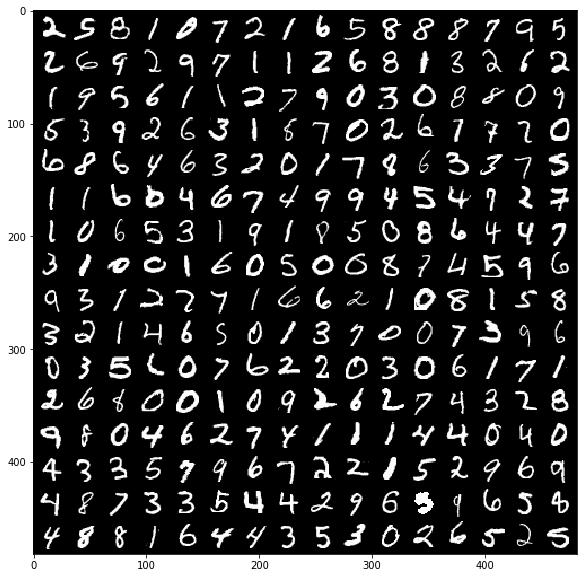

Classes: 
    2     5     8     1     0     7     2     1     6     5     8     8     8     7     9     5
    2     6     9     2     9     7     1     1     2     6     8     1     3     2     6     2
    1     9     5     6     1     1     2     7     9     0     3     0     8     8     0     9
    5     3     9     2     6     3     1     8     7     0     2     6     7     7     2     0
    6     8     6     4     6     3     2     0     1     7     8     6     3     3     7     5
    1     1     6     0     4     6     7     4     9     9     4     5     4     7     2     7
    1     0     6     5     3     1     9     1     8     5     0     8     6     4     4     7
    3     1     0     0     1     6     0     5     0     0     8     7     4     5     9     6
    9     3     1     2     7     7     1     6     6     2     1     0     8     1     5     8
    3     2     1     4     6     5     0     1     3     7     0     0     7     3     9     6
    0     3     5     6     0 

In [74]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):
  plt.rcParams['figure.figsize'] = [10, 10]
  # Mnist does not need normalization
  # img = img / 2 + 0.5     # unnormalize
  count = img.shape[0]
  nrow = int( np.sqrt(count) )
  img = torchvision.utils.make_grid(img, nrow=nrow)
  npimg = img.numpy()
  npimg = np.transpose(npimg, (1, 2, 0))
  plt.imshow(npimg)
  plt.show()


# get some random training images (First batch)
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show dim
print( "Dimensions of input: ", images.shape )
# show images
print( "Plot of batch: " )
imshow(images)
# print labels
classes = [ str(i) for i in range(10)]
nrow = int( np.sqrt(bs) )
print('Classes: ' )
for l in range(nrow):
  print(' '.join('%5s' % classes[labels[j+nrow*l]] for j in range(nrow)))

# II. ML

## II.1. Definition of the neural net

In [75]:
class AE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(AE, self).__init__()
        # Non-linearity
        self.non_linearity = torch.sin
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = self.non_linearity(self.fc1(x))
        h = self.non_linearity(self.fc2(h))
        h = self.non_linearity(self.fc3(h))
        return h # Latent variable z
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = z
        h = self.non_linearity( self.fc4(h))
        h = self.non_linearity( self.fc5(h))
        return self.non_linearity( self.fc6(h) ) 
    
    def forward(self, x):
        z = self.encoder(x.view(-1, MNIST_SIZE*MNIST_SIZE))
        return self.decoder(z), z

# build model
ae = AE(x_dim=MNIST_SIZE*MNIST_SIZE, h_dim1= 512, h_dim2=256, z_dim=Z_DIM)
if torch.cuda.is_available():
    ae.cuda()

In [76]:
print(ae)

print( "Parameters: %d"%len([ x for x in ae.parameters()]) )
for param in ae.parameters():
  print(type(param.data), param.size())

AE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)
Parameters: 12
<class 'torch.Tensor'> torch.Size([512, 784])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([256, 512])
<class 'torch.Tensor'> torch.Size([256])
<class 'torch.Tensor'> torch.Size([2, 256])
<class 'torch.Tensor'> torch.Size([2])
<class 'torch.Tensor'> torch.Size([256, 2])
<class 'torch.Tensor'> torch.Size([256])
<class 'torch.Tensor'> torch.Size([512, 256])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([784, 512])
<class 'torch.Tensor'> torch.Size([784])


## II.2. Optimizer and loss functions

In [77]:
optimizer = optim.Adam(ae.parameters())
    
# Loss = MSE 
# Inputs:
#   recon_data: reconstructed data via decoder
#   data: original data
#   z: latent variable
def loss_function(recon_data, data, z):
    MSE = F.mse_loss(recon_data, data.view(-1, MNIST_SIZE*MNIST_SIZE), reduction='mean')
    return MSE*1e4

In [78]:
from tqdm import tqdm_notebook as tqdm

log_loss = []
  
def train(epoch):
    ae.train()
    train_loss = 0
    print("Epoch %d"%epoch)
    t = tqdm( train_loader, position=0 )
    for (data, labels) in t:
        data = data.cuda()
        optimizer.zero_grad()
        # Forward
        recon_batch, z = ae(data)
        loss = loss_function(recon_batch, data, z)
        # Backpropagate
        loss.backward()
        train_loss += loss.item()
        log_loss.append( loss.item() )
        optimizer.step()
        # Progress bar
        t.set_description_str(desc="Average train loss: %.6f"% (train_loss / len(train_loader.dataset)) )
    # end for
    return train_loss

def test():
    ae.eval()
    test_loss= 0
    with torch.no_grad():
        t = tqdm( test_loader, desc="Test", position=1 )
        for data, _ in t:
            data = data.cuda()
            recon, z = ae(data)
            # sum up batch loss
            test_loss += loss_function(recon, data, z).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Total test set loss: {:.4f}'.format(test_loss))
    print("")
    return test_loss

## II. 3. Train loop

In [79]:
# Launch
loss_history = []
for epoch in range(1, num_epochs):
  train_loss = train(epoch)
  test_loss  = test()
  loss_history.append(train_loss)

Epoch 1



====> Total test set loss: 2.2109

Epoch 2



====> Total test set loss: 2.1185

Epoch 3



====> Total test set loss: 2.0107

Epoch 4



====> Total test set loss: 1.9249

Epoch 5



====> Total test set loss: 1.8876

Epoch 6



====> Total test set loss: 1.8502

Epoch 7



====> Total test set loss: 1.8241

Epoch 8



====> Total test set loss: 1.8139

Epoch 9



====> Total test set loss: 1.7784



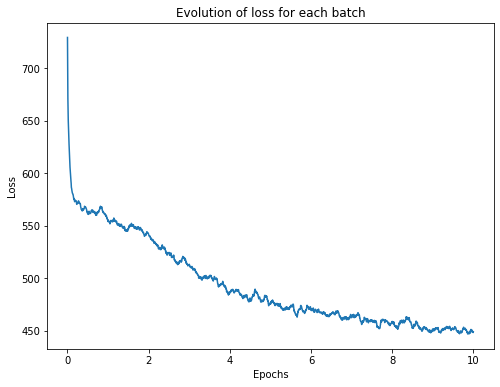

In [93]:
# Form mobile average over window of size N
# That is to say, N batches
N = 20
average_loss = np.convolve(log_loss, np.ones((N,))/N)[(N-1):-N]
time = np.linspace(0, num_epochs, len(average_loss) )

# Log
plt.figure(figsize=(8, 6))
plt.title('Evolution of loss for each batch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot( time, average_loss )
axes = plt.gca()


## II. 4. Extracting latent variables and labels

In [94]:
from tqdm import tqdm

# Fetch data for plot 
latent_variables = []
batch_idx = 0
for (data, labels) in tqdm( train_loader, position=0 ):
    batch_idx += 1
    data = data.cuda()
    # Forward
    recon_batch, uniforms = ae(data)
    # Record means and labels
    uniforms = uniforms.cpu().detach().numpy()
    labels = labels.numpy()
    values =  [ [uniforms[i], labels[i]] for i in range(len(uniforms)) ]
    latent_variables.extend( values )
#
print("Reality check:")
print(latent_variables[:2])
# Split latent variables into labels and coordinates
labels  = [ m[1] for m in latent_variables ]
zLatent = np.array( [ m[0] for m in latent_variables ] )

100%|██████████| 235/235 [00:01<00:00, 234.90it/s]


Reality check:
[[array([0.01803262, 0.9924161 ], dtype=float32), 2], [array([-0.34331736, -0.55173814], dtype=float32), 4]]


# III. Plotting

Either in 2D or 3D depending on the space of latent variables

## III.1. Plotting in 2D

This is only if Z_DIM=2

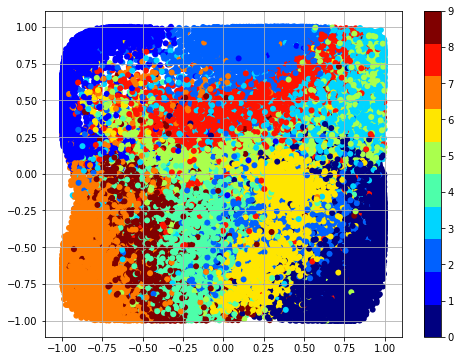

In [95]:
import matplotlib.pyplot as plt
import numpy as np
  
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)
  
assert( Z_DIM == 2)
  
#Classes
N = 10
#Formatting
x = [ e[0] for e in zLatent ]
y = [ e[1] for e in zLatent ]
#Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=labels, marker='o', edgecolor='none', cmap=discrete_cmap(N, 'jet'))
plt.colorbar(ticks=range(N))
axes = plt.gca()
plt.grid(True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random sample:
Dimensions of input:  torch.Size([576, 784])


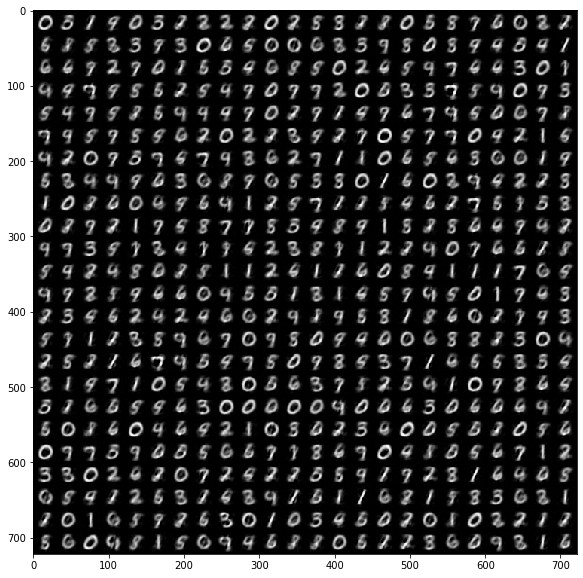

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Manifold plot:
Dimensions of input:  torch.Size([576, 784])


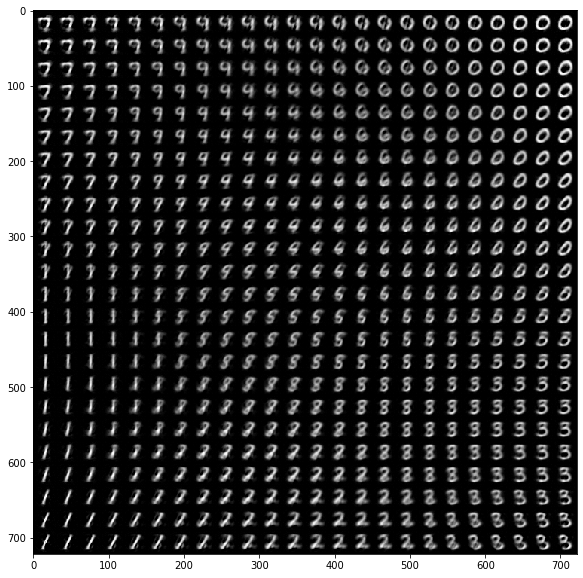

In [97]:
assert( Z_DIM == 2)

import numpy as np
import os

if not os.path.exists('./samples'):
  os.mkdir('./samples')

GRID_SIZE = 24
  
with torch.no_grad():
    print("Random sample:")
    z = 2*torch.rand(GRID_SIZE*GRID_SIZE, 2).cuda()-1
    sample = ae.decoder(z).cuda()
    print( "Dimensions of input: ", sample.shape )
    sample = sample.view(GRID_SIZE*GRID_SIZE, 1, 28, 28).cpu()
    imshow( sample )
    save_image(sample, './samples/randomSample' + '.png')
    #
    print("Manifold plot:")
    xx = np.linspace(-1, 1, GRID_SIZE)
    yy = np.linspace(-1, 1, GRID_SIZE)
    z = torch.zeros([GRID_SIZE*GRID_SIZE,Z_DIM])
    for i in range(GRID_SIZE):
      for j in range(GRID_SIZE):
        z[i+GRID_SIZE*j] = torch.tensor( [xx[i], yy[j]] )
    z = z.cuda()
    sample = ae.decoder(z).cuda()
    print( "Dimensions of input: ", sample.shape )
    sample = sample.view(GRID_SIZE*GRID_SIZE, 1, 28, 28).cpu()
    imshow( sample )
    save_image(sample, './samples/manifoldPlot' + '.png')
